# 3 Linear Regression
Based on book "Introduction to Statitical Learning" by Tibshirani & Hastie
Data in book avaliable from https://github.com/JWarmenhoven/ISLR-python/tree/master/Notebooks/Data

additional acknowledgements
* The python adaptation of the book by JWarmenhoven (https://github.com/JWarmenhoven/ISLR-python)

#### Contents:
* [3.1 Simple Linear Regression](#3.1)
    * [3.1.1 Estimating the Coefficients](#3.1.1)
    * [3.1.2 Assessing the Accuracy of the Coefficient Estimates](#3.1.2)
    * [3.1.3 Assesing the Accuracy of the Model ](#3.1.3)
   

In [56]:
from sympy import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm

import statsmodels.api as sm
import statsmodels.formula.api as smf

## 3.1 Simple Linear Regression <a class="anchor" id="3.1"></a>
\begin{equation}
Y \approx \beta_0 +\beta_1X
\end{equation}
where $Y$ is the *response* variable and $X$ is the *predictor* variable. Here $\beta_0$ and $\beta_1$ are two unknown constants (known as the model *coefficients* or *parameters*) that represent the *intercept* and *slope* terms in the linear model.

Once we have used the training data to produce estimates $\hat{\beta_0}$ and $\hat{\beta_1}$, we can predict $\hat{y}$ using $x$ by computing
\begin{equation}
\hat{y} = \hat{\beta_0} +\hat{\beta_1}x
\end{equation}


The following example advertising dataset we want to model the response of sales in relation to the amount of TV advertising:
\begin{equation}
sales \approx \beta_0 +\beta_1TV
\end{equation}

In [57]:
# get advertising dataset
advertising_data_url=r'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Advertising.csv'
df=pd.read_csv(advertising_data_url,index_col=0)
df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


### 3.1.1 Estimating the Coefficients <a class="anchor" id="3.1.1"></a>

We want the linear model to fit the training data as *close* as possible. We do this by calculating $\hat{\beta_0}$ and $\hat{\beta_1}$ such that they minimise the *least-squares* criterion. The *residual sum of squares* (RSS) is defined as
\begin{equation}
RSS=e_1^2+e_2^2+\cdots+e_n^2
\end{equation}
where $e_i$ is the error in the model for the ith data point (\\( e_i = y_i - \hat{y_i}\\)) and $n$ is the number of data points in the training dataset.

It can be shown that there is an analytical solution:
\begin{equation}
\hat{\beta_1}=\frac{\sum_{i=1}^n{(x_i-\bar{x})(y_i-\bar{y})}}{\sum_{i=1}^n{(x_i-\bar{x})^2}},\\
\hat{\beta_0}=\bar{y}=\hat{\beta_1}\bar{x}.
\end{equation}
Therefore, for the advertising dataset we get the following:

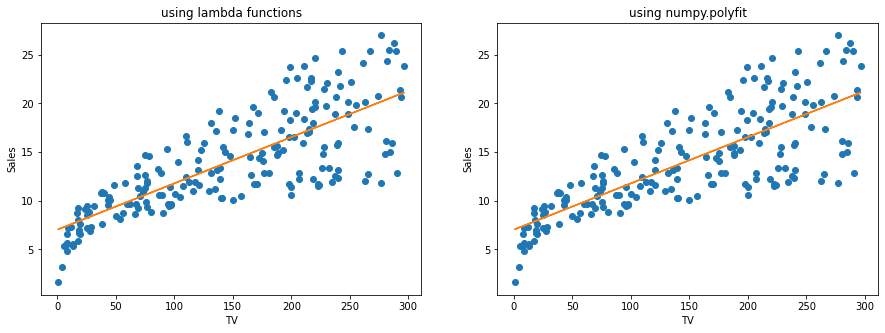

In [58]:
# define the above functions
beta_1_fun = lambda x,y: ((x-x.mean())*(y-y.mean())).sum() / ((x-x.mean())**2).sum()
beta_0_fun = lambda x,y: y.mean() - beta_1_fun(x,y)*x.mean()

# define x and y
x=df['TV']
y=df['Sales']
beta_0, beta_1 = beta_0_fun(x,y), beta_1_fun(x,y)

# this can also be done in one line:
beta_1_np, beta_0_np = np.polyfit(x, y, 1)

# plot comparison
n_plots=2
fig, ax = plt.subplots(1,n_plots,figsize=(15,5))
for i in range(n_plots):
    ax[i].plot(x, y, 'o')
    ax[i].set_xlabel('TV')
    ax[i].set_ylabel('Sales')
ax[0].set_title('using lambda functions')
ax[0].plot(x, beta_0 + beta_1*x)
ax[1].set_title('using numpy.polyfit')
ax[1].plot(x, beta_0_np + beta_1_np*x);

The model shows that an additional $1000 spent on TV advertising will see an additional 47.5 sales


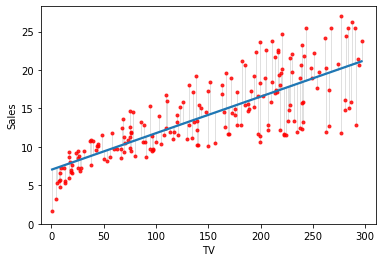

In [59]:
# seaborn automatically plots a ployfit line of any order if you want to look quickly at the relationship
sns.regplot(df.TV, df.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

# add joing vertical lines if you want:
for i in range(df.shape[0]):
    plt.plot([df.TV.iloc[i],df.TV.iloc[i]],[df.Sales.iloc[i],beta_0 + beta_1*df.TV.iloc[i]],color='#e0e0e0',linewidth=1, zorder=0)

print('The model shows that an additional $1000 spent on TV advertising will see an additional {:0.1f} sales'.format(beta_1*1000))

To show how the RSS varies for a linear model of order=1:

minimum RSS is 2.10


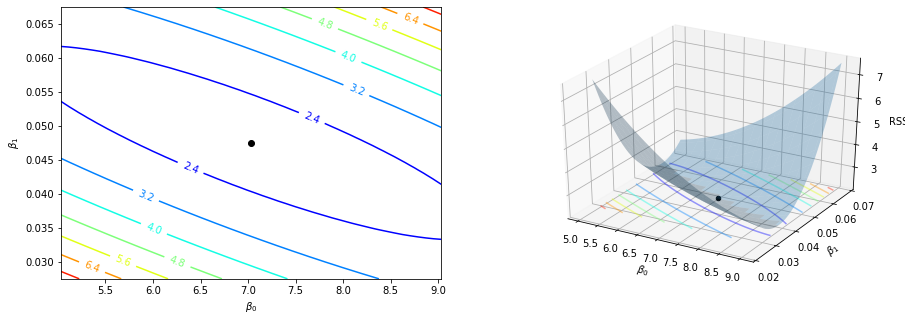

In [60]:
def make_RSS_plots(beta_0,beta_1,x,y):
    # Create grid coordinates for plotting
    B0 = np.linspace(beta_0-2, beta_0+2, 50)
    B1 = np.linspace(beta_1-0.02, beta_1+0.02, 50)
    xx, yy = np.meshgrid(B0, B1, indexing='xy')
    Z = np.zeros((B0.size,B1.size))

    # Calculate Z-values (RSS) based on grid of coefficients
    for (i,j),_ in np.ndenumerate(Z):
        Z[i,j] =((y - (xx[i,j]+x*yy[i,j]))**2).sum()/1000
    print('minimum RSS is {:0.2f}'.format(Z.min()))
    
    # make left figure a contour plot
    fig = plt.figure(figsize=(15,5))
    ax1=fig.add_subplot(1,2,1)
    CS=ax1.contour(xx, yy, Z, cmap=plt.cm.jet)
    ax1.scatter(beta_0, beta_1, c='k')
    ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
    ax1.set_xlabel(r'$\beta_0$')
    ax1.set_ylabel(r'$\beta_1$')
    # make right figure a surface over a contour plot
    ax2=fig.add_subplot(1,2,2,projection='3d')
    ax2.projection='3d'
    ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
    ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.jet,
                alpha=0.4)
    ax2.scatter3D(beta_0, beta_1, Z.min(), c='k')
    ax2.set_zlabel('RSS')
    ax2.set_zlim(Z.min(),Z.max())
    ax2.set_ylim(0.02,0.07)
    ax2.set_xlabel(r'$\beta_0$')
    ax2.set_ylabel(r'$\beta_1$')

    
make_RSS_plots(beta_0,beta_1,x,y)

**Centered vs Uncentered**

The previous example was uncentered, however if we rescale the x-axis around the x mean, we still get the same gradient, however a different intercept, and the RSS graphs look more visually appealing.

When **NOT** to use centering (https://www.theanalysisfactor.com/when-not-to-center-a-predictor-variable-in-regression/):
1. If all continuous predictors have a meaningful value of 0.

2. If you have no interaction terms involving that predictor.

3. And if there are no values that are particularly meaningful.


Centering can be done easily in the scikit-learn module:

minimum RSS is 2.10


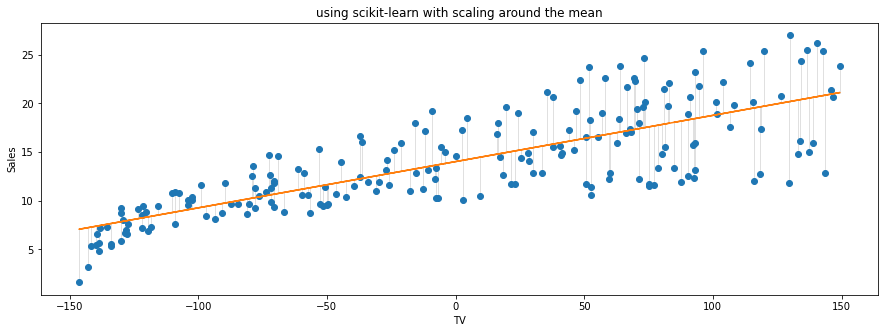

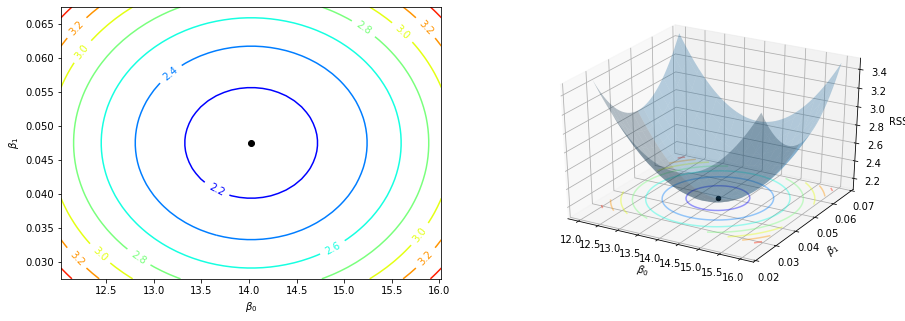

In [61]:
#define linear model
regr = skl_lm.LinearRegression()
# scale the x data
X_centering = scale(df.TV, with_mean=True, with_std=False).reshape(-1,1)
# X_no_centering = df.TV.to_numpy().reshape(-1, 1)
y = df.Sales

# fit the model
regr.fit(X_centering,y)

# plot scatter
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(X_centering,y,'o')
ax.set_xlabel('TV')
ax.set_ylabel('Sales')
ax.set_title('using scikit-learn with scaling around the mean')
ax.plot(X_centering, regr.intercept_ + regr.coef_[0]*X_centering);
# add joing vertical lines if you want:
for i in range(df.shape[0]):
    plt.plot([X_centering[i],X_centering[i]],[y.iloc[i],regr.intercept_ + regr.coef_[0]*X_centering[i]],color='#e0e0e0',linewidth=1, zorder=0)


# plot RSS plots
make_RSS_plots(regr.intercept_,regr.coef_[0],X_centering.flatten(),y)

### 3.1.2 Assessing the Accuracy of the Coefficient Estimates <a class="anchor" id="3.1.2"></a>
If the true relationship between $X$ and $Y$ is in the form:
\begin{equation}
Y=f(X)+\epsilon,
\end{equation}
then if $f$ is approximated by a linear function, the relationship is:
\begin{equation}
Y=\beta_0+\beta_1X+\epsilon.
\end{equation}


Below, in the left figure, you can see an example of how the population model (<span style="color:red">the red line</span>) \\(Y=2+3X\\) is used to generate 100 random normally distributed points, and how the linear least-squares (<span style="color:green">the green line</span>) fits. Although it is not quite the same as the true relationship, it is a pretty good representation. In the right figure we can see than for 10 different randomly generated sets of points, the linear fits (<span style="color:blue">the blue lines</span>) are a good representation everytime.

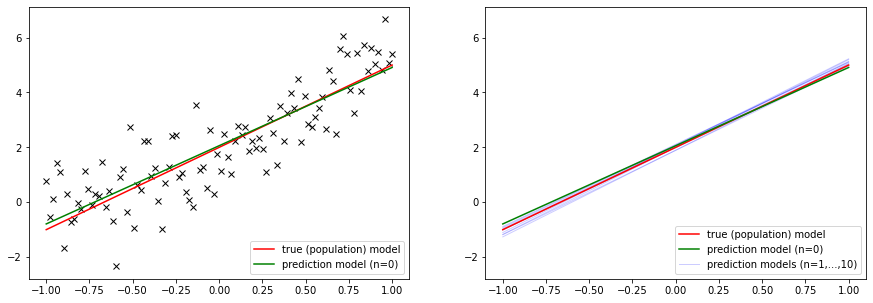

In [62]:
#error function
mu=0
sigma=1
n=100
rand_norm = lambda mu, sigma, n: sigma * np.random.randn(n) + mu

# population model
y_pop = lambda x, err: 2+3*x+err

# make 10 random normally distributed datasets from the population model
y1=[]
err=[]
x1=np.linspace(-1,1,n)
for i in range(10):
    np.random.seed(i)
    err.append(rand_norm(mu, sigma, n))
    y1.append(y_pop(x1,err[i]))
    
# left figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(x1,y1[0],'kx')
ax[0].plot([x1.min(),x1.max()],y_pop(np.array([x1.min(),x1.max()]),0),'r')
beta_0_1, beta_1_1 = beta_0_fun(x1,y1[0]), beta_1_fun(x1,y1[0])
ax[0].plot(x1, beta_0_1 + beta_1_1*x1,'g');

# right figure
ax[1].set_ylim(ax[0].get_ylim())
h1=ax[1].plot([x1.min(),x1.max()],y_pop(np.array([x1.min(),x1.max()]),0),'r')
beta_0_1, beta_1_1 = beta_0_fun(x1,y1[0]), beta_1_fun(x1,y1[0])
h2=ax[1].plot(x1, beta_0_1 + beta_1_1*x1,'g');
for i in range(1,10):
    beta_0_1, beta_1_1 = beta_0_fun(x1,y1[i]), beta_1_fun(x1,y1[i])
    h3=ax[1].plot(x1, beta_0_1 + beta_1_1*x1,'b',zorder=0,linewidth=1,alpha=0.2);
    
# legends
ax[0].legend([h1[0],h2[0]],['true (population) model','prediction model (n=0)'],loc=4);
ax[1].legend([h1[0],h2[0],h3[0]],['true (population) model','prediction model (n=0)','prediction models (n=1,...,10)'],loc=4);

For the purpose of assessing the accuracy of the coefficients in the model, it is useful to know the population mean $\mu$ of $Y$. $\mu$ is unknown, however we do we have $n$ observations from $Y$. We can use the sample mean $\bar{y}$ as a reasonable estimate for the population mean ($\hat{\mu}=\bar{y}$). In the same way we can reasonably accurately esimate $\hat{\beta_0}$ and $\hat{\beta_1}$ over a large number of unbiased observations.

We start to define useful statistical metrics to define the error we observe in the parameters.

Firstly, we want to know how far off a single estimate would be from the true value.
Generally, this is done by estimating the *standard error*, written as SE(.). For the mean this calculated by:
\begin{equation}
Var(\hat{\mu})=SE(\hat{\mu})^2=\frac{\sigma^2}{n}
\end{equation}
To see how close the estimates $\hat{\beta_0}$ and $\hat{\beta_1}$ are to the true values, we can use the following formulas:
\begin{equation}
SE(\hat{\beta_0})^2=\sigma^2 \left[\frac{1}{n}+\frac{\bar{x}^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}\right],\\
SE(\hat{\beta_1})^2=\frac{\sigma^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}},
\end{equation}
where $\sigma^2=Var(\epsilon)$. For these formulas to be strictly valid, we need to assume that the errors $\epsilon_i$ for each observation are uncorrelated with common varience $\sigma^2$.

In general, $\sigma$ is not know, but can be estimated from the data, and is known as the *residual standard error* (RSE).
\begin{equation}
RSE=\sqrt{\frac{RSS}{n-2}}
\end{equation}

SE can be used to compute *confidence intervals*. For linear regression, the 95% confidence interval for $\beta_0$ and $\beta_1$ is approximately
\begin{equation}
\hat{\beta_0} \pm 2\cdot SE(\hat{\beta_0}),\\
\hat{\beta_1} \pm 2\cdot SE(\hat{\beta_1}).
\end{equation}

In [63]:
RSE_fun = lambda RSS,n: (RSS/(n-2))**0.5
SE_beta0_fun = lambda RSS,x: (RSE_fun(RSS,len(x))**2*(1/len(x)+x.mean()**2/((x-x.mean())**2).sum()))**0.5
SE_beta1_fun = lambda RSS,x: (RSE_fun(RSS,len(x))**2/((x-x.mean())**2).sum())**0.5
CIs = lambda SE_x,x: [x-2*SE_x,x+2*SE_x]

RSS=sum([(y.iloc[i]-(beta_0 + beta_1*x.iloc[i]))**2 for i in range(len(y))])
SE_beta0=SE_beta0_fun(RSS,x)
SE_beta1=SE_beta1_fun(RSS,x)

print('SE(beta_0)={:0.4f}'.format(SE_beta0))
print('SE(beta_1)={:0.4f}'.format(SE_beta1))
print('confidence intervals for beta_0=[{:0.4f},{:0.4f}]'.format(*CIs(SE_beta0,beta_0)))
print('confidence intervals for beta_1=[{:0.4f},{:0.4f}]'.format(*CIs(SE_beta1,beta_1)))


SE(beta_0)=0.4578
SE(beta_1)=0.0027
confidence intervals for beta_0=[6.1169,7.9483]
confidence intervals for beta_1=[0.0422,0.0529]


SEs can also be used to perform *hypothesis tests* on the coefficients. The most common test has a *null hypothesis*:
\begin{equation}
H_0: \text{There is no relationship between } X \text{ and } Y\\
\text{i.e.}\quad H_0:\beta_1=0
\end{equation}
and an *alternative hypothesis*:
\begin{equation}
H_a: \text{There is some relationship between } X \text{ and } Y\\
\text{i.e.}\quad H_a:\beta_1\neq0
\end{equation}

To test $H_0$, we need to determine that $\hat{\beta_1}$ is sufficiently far from $0$ such that we can be confident that $\beta_1$ is non-zero. To do this we use $SE(\hat{\beta_1})$, as if it is small only small values of $\hat{\beta_1}$, and vice-versa. In practice, we compute a *t-statistic*:
\begin{equation}
t=\frac{\hat{\beta_1}-0}{SE(\hat{\beta_1})}
\end{equation}
which measures the number of standard deviations that $\hat{\beta_1}$ is away from $0$. We can now calculate the probability of observing a value $\geq |t|$ assuming $\beta_1=0$. We call this the *p-value*. In general, a small p-value indicates that it is unlikely that the relationship between the predictor and responce is due to chance, hence we *reject* $H_0$ - declaring that there is a relationship between $X$ and $Y$.

Typical cutoffs for rejecting $H_0$ are $5\%$ and $1\%$. The number of degress of freedom for the above example is $n-2$.

In [64]:
# calculate t and p values as above
t=beta_1/SE_beta1
p = 1 - stats.t.cdf(t,df=len(y)-2)

print('beta_1 t-statistic={:0.4f}'.format(t))
print('beta_1 p-value={:0.4f} (4 d.p.)'.format(p))

beta_1 t-statistic=17.6676
beta_1 p-value=0.0000 (4 d.p.)


The previous few steps can be easily calculated via the *statsmodel* module, as can be seen below. We can see that both $\hat{\beta_0}$ (Intercept) and $\hat{\beta_1}$ (TV) have very low p-values, hence $\beta_0 \neq 0$ and $\beta_1 \neq 0$.

In [65]:
# Table 3.1 in ISLR book
est = smf.ols('Sales ~ TV', df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


### 3.1.3 Assesing the Accuracy of the Model <a class="anchor" id="3.1.3"></a>